In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from darts.models import VARIMA
from darts.models import RNNModel
from darts.metrics import mae
from darts.timeseries import TimeSeries
from sklearn.model_selection import train_test_split
from genrisk.generation import TCNVAE
from genrisk.utils.create_immutable_features import AddImmutable
import torch
from torch.utils.data import Dataset

# DATA

In [78]:
data = pd.read_csv('/home/alina/git-projects/genrisk/data_ETT/ETTh1.csv')

In [79]:
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [80]:
time_col = 'date'
value_cols = ['HUFL','HULL','MUFL','MULL','LUFL','LULL','OT']

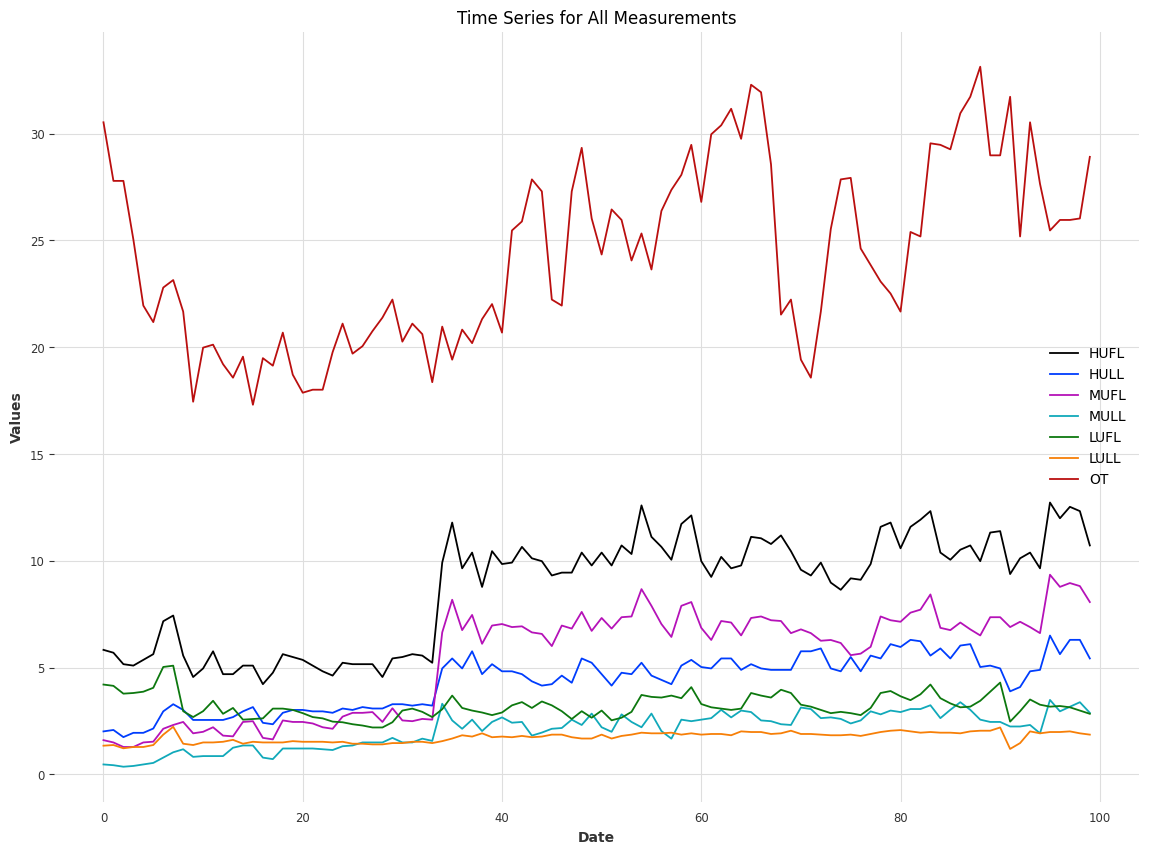

In [81]:
data_plot = data[:100]

plt.figure(figsize=(14, 10))
for column in value_cols:
    plt.plot(data_plot.index, data_plot[column], label=column)

plt.title('Time Series for All Measurements')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [82]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [83]:
train_data[time_col] = pd.to_datetime(train_data[time_col]) 
train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)

test_data[time_col] = pd.to_datetime(test_data[time_col])
test_data['time_idx'] = ((test_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)


/tmp/ipykernel_5178/484976141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[time_col] = pd.to_datetime(train_data[time_col])
/tmp/ipykernel_5178/484976141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)
/tmp/ipykernel_5178/484976141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [84]:
train_data = pd.melt(
    train_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [85]:
train_data

,date,time_idx,group_col,value
0,2016-07-01 00:00:00,0,HUFL,5.827
1,2016-07-01 01:00:00,1,HUFL,5.693
2,2016-07-01 02:00:00,2,HUFL,5.157
3,2016-07-01 03:00:00,3,HUFL,5.090
4,2016-07-01 04:00:00,4,HUFL,5.358
...,...,...,...,...
97547,2018-02-01 11:00:00,13931,OT,4.713
97548,2018-02-01 12:00:00,13932,OT,4.291
97549,2018-02-01 13:00:00,13933,OT,4.291
97550,2018-02-01 14:00:00,13934,OT,6.261


In [86]:
test_data = pd.melt(
    test_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [87]:
test_data

,date,time_idx,group_col,value
0,2018-02-01 16:00:00,13936,HUFL,3.684
1,2018-02-01 17:00:00,13937,HUFL,13.329
2,2018-02-01 18:00:00,13938,HUFL,15.606
3,2018-02-01 19:00:00,13939,HUFL,18.687
4,2018-02-01 20:00:00,13940,HUFL,18.018
...,...,...,...,...
24383,2018-06-26 15:00:00,17415,OT,10.904
24384,2018-06-26 16:00:00,17416,OT,11.044
24385,2018-06-26 17:00:00,17417,OT,10.271
24386,2018-06-26 18:00:00,17418,OT,9.778


# FORECASTING

In [59]:
class SlidingWindowDataset(Dataset):
    def __init__(self, df, target_columns, window_size, step_size):
        self.window_size = window_size
        self.target_columns = target_columns
        self.df = df
        self.step_size = step_size
    
    def __len__(self):
        return (len(self.df) - self.window_size + 1) // self.step_size
    
    def __getitem__(self, idx):
        target = self.df[self.target_columns].iloc[range(idx*self.step_size, idx*self.step_size + self.window_size)]
        return torch.FloatTensor(target.values)


In [117]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

max_encoder_length = 24*3
max_prediction_length = 24

dataset_train = TimeSeriesDataSet(
    train_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
)

dataset_test = TimeSeriesDataSet(
    test_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
)

dataloader_train = dataset_train.to_dataloader(train=True, batch_size=64, num_workers=0)
dataloader_test = dataset_test.to_dataloader(train=False, batch_size=64, num_workers=0)


In [118]:
baseline_model = Baseline()

baseline_predictions = baseline_model.predict(dataloader_test, return_y=True)
print(baseline_predictions.output.shape)
print(baseline_predictions.y[0].shape)


MAE()(baseline_predictions.output.reshape(-1), baseline_predictions.y[0])

/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 43 for tensor number 370 in the list.

In [119]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    dataset_train,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 15.6k



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 32     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 38: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, v_num=2, train_loss_step=0.607, val_loss=0.906, train_loss_epoch=0.695]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

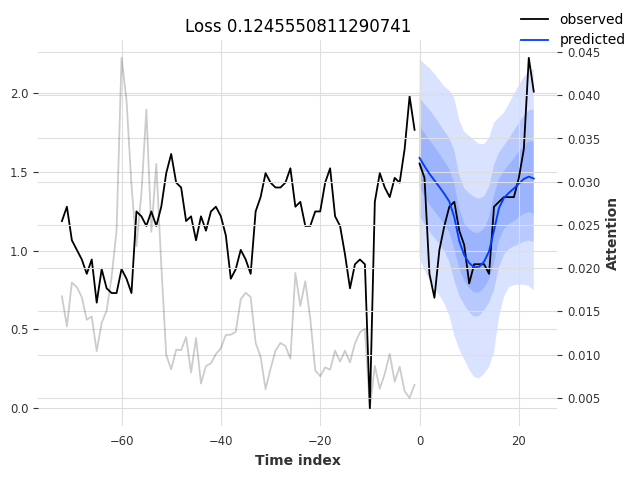

In [120]:
trainer.fit(
    tft,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_test,
)

# VAE

conditional

In [27]:
train_data_immutable = train_data.copy()
train_data_immutable = train_data_immutable.set_index('date')
train_data_immutable.index = pd.to_datetime(train_data_immutable.index)
train_data_immutable = AddImmutable(train_data_immutable, ['hoursofday']).get()

In [28]:
train_data_immutable.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,hoursofday_cos,hoursofday_sin
date,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,1.000000,0.000000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,0.965926,0.258819
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,0.866025,0.500000
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,0.707107,0.707107
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,0.500000,0.866025


In [29]:
gen = TCNVAE(
    target_columns=value_cols, 
    conditional_columns=['hoursofday_cos', 'hoursofday_sin'],
    hidden_dim=16,
    latent_dim=1,
    num_layers=2,
    kernel_size=3,
    window_size=20,
    batch_size=16,
    num_epochs=1,
    verbose=True,
    lr=0.001,
)
gen.fit(train_data_immutable)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type        | Params | Mode 
---------------------------------------------
0 | enc  | _TCNEncoder | 3.0 K  | train
1 | dec  | _TCNDecoder | 2.7 K  | train
---------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 870/870 [00:23<00:00, 37.65it/s, v_num=15, train_loss=578.0]  

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 870/870 [00:23<00:00, 37.64it/s, v_num=15, train_loss=578.0]


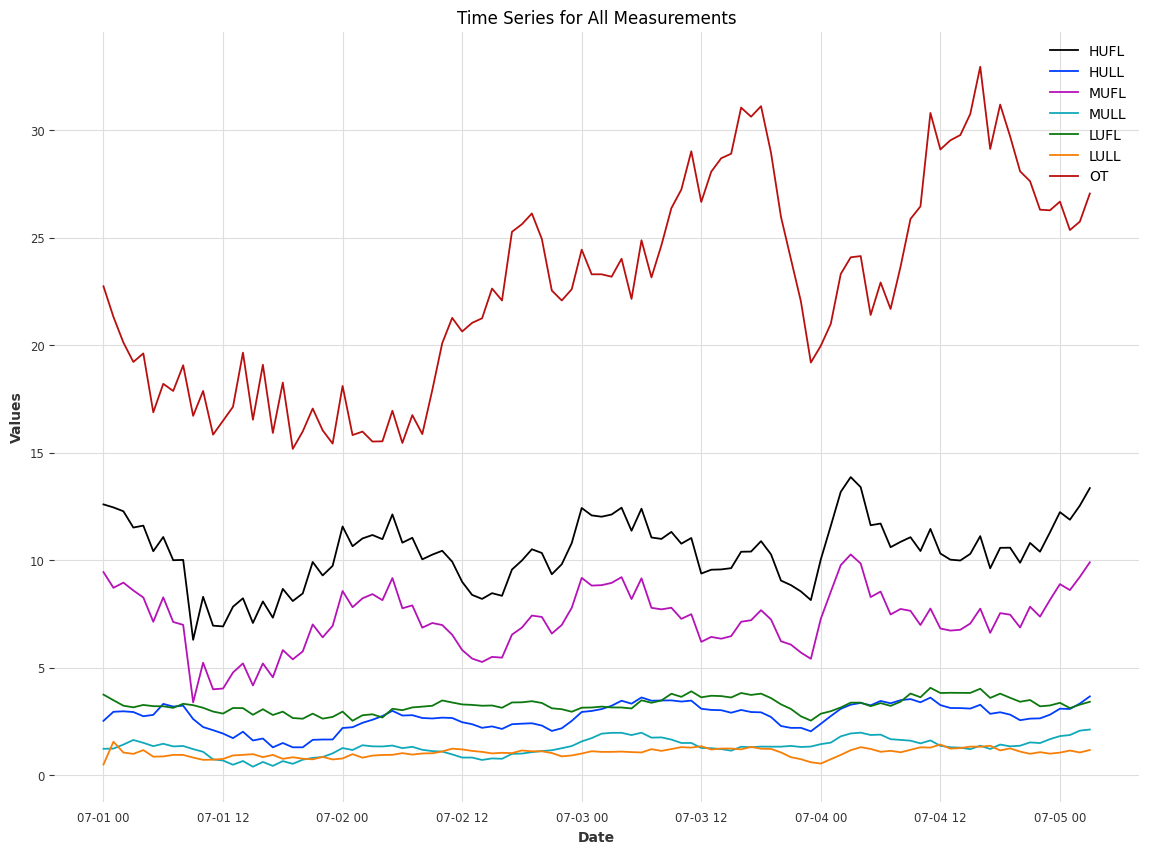

In [34]:
fake_data = gen.sample(train_data_immutable, n_samples=10)
data_plot = fake_data[0][:100]

plt.figure(figsize=(14, 10))
for column in value_cols:
    plt.plot(data_plot.index, data_plot[column], label=column)

plt.title('Time Series for All Measurements')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# AUGMENTATION WITH VAE

conditional

In [36]:
fake_data = gen.sample(train_data_immutable, n_samples=1)[0]

In [37]:
import torch
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    def __init__(self, dfs, target_columns, window_size, step_size):
        self.window_size = window_size
        self.target_columns = target_columns
        self.dfs = dfs
        self.step_size = step_size

        self.lengths = [(len(df) - self.window_size + 1) // self.step_size for df in self.dfs]

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        for i, length in enumerate(self.lengths):
            if idx < length:
                target = self.dfs[i][self.target_columns].iloc[range(idx * self.step_size, idx * self.step_size + self.window_size)]
                return torch.FloatTensor(target.values)
            else:
                idx -= length

        raise IndexError("Index out of range")


# WCR

In [ ]:
shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha)
shift_model.fit(test_input_seq, test_lstm_error)

In [ ]:
shift_model.mask[:100]

In [ ]:
risk_date = test_input_seq[shift_model.mask].index[0]
risk_idx = np.where(test_target.index == risk_date)[0][0]

plt.figure(figsize=(10, 3))
plt.plot(test_target.iloc[risk_idx-10:risk_idx+100])
plt.show()